Import a video and use mediaPip to extract pose landmarkers for each frame

In [1]:
from utils.videoProcessingFunctions import *
from utils.poseFunctions import *

import matplotlib.pyplot as plt

BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# model_path = "assets/pose_landmarker_heavy.task"
model_path = "assets/pose_landmarker_lite.task"
video_path = "media/realspeed/Cross.mp4"
# video_path = "media/realspeed/hook.mp4"
options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.VIDEO,
    output_segmentation_masks=True,
)
pose_landmarker_results = get_landmarker_results_from_video(
    video_path, options, end_time_ms=25 * 1e3
)

fps=29.997469672424373


c:\Users\adware\Desktop\boxing_dynamics\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Can't read frame. Skipping...


In [4]:
pose_landmarker_results[0]["landmarker_results"].pose_world_landmarks[0][14]

Landmark(x=-0.1730673760175705, y=-0.3621215522289276, z=-0.21377183496952057, visibility=0.9974097609519958, presence=0.9992610812187195)

plot the visibility of a point over time

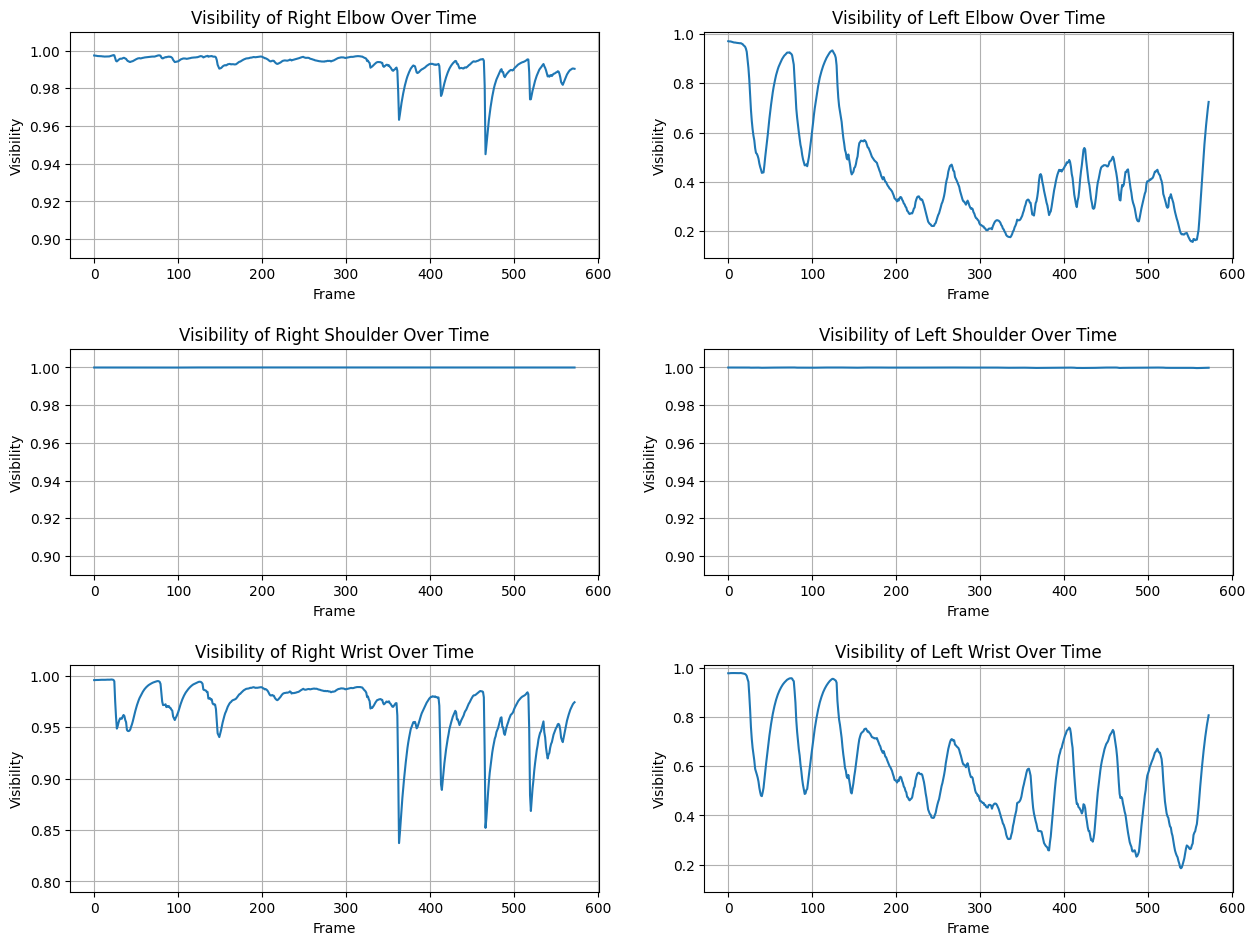

In [6]:
import numpy as np

from utils.videoProcessingFunctions import get_keypoint_name_from_index

def plot_visibility_over_time(pose_landmarker_results, landmark_index):
    keypoint_name = str(get_keypoint_name_from_index(landmark_index))
    keypoint_name = keypoint_name.replace("_", " ").title()

    num_frames = len(pose_landmarker_results)
    visibilities = np.zeros(num_frames)
    for i in range(num_frames):
        visibilities[i] = pose_landmarker_results[i]["landmarker_results"].pose_world_landmarks[0][landmark_index].visibility

    min_visibility = np.min(visibilities)
    max_visibility = np.max(visibilities)

    plt.plot(visibilities)
    plt.xlabel("Frame")
    plt.ylabel("Visibility")
    plt.title(f"Visibility of {keypoint_name} Over Time")
    # plt.ylim(np.round(min_visibility, decimals=1), np.round(max_visibility, decimals=1))
    plt.ylim(
        np.floor(min_visibility * 10) / 10 - 0.01,
        np.ceil(max_visibility * 10) / 10 + 0.01
    )
    plt.grid()

# create a 3,2 subplot of visibility over time for the following keypoints:
# Right Elbow (14), Wrist (16), Shoulder (12); 
# Left Elbow (13), Wrist (15), Shoulder (11)
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
plt.subplot(3, 2, 1)    
plot_visibility_over_time(pose_landmarker_results, landmark_index=14)  # Right Elbow
plt.subplot(3, 2, 2)
plot_visibility_over_time(pose_landmarker_results, landmark_index=13)  # Left Elbow
plt.subplot(3, 2, 3)   
plot_visibility_over_time(pose_landmarker_results, landmark_index=12)  # Right Shoulder
plt.subplot(3, 2, 4)
plot_visibility_over_time(pose_landmarker_results, landmark_index=11)  # Left Shoulder
plt.subplot(3, 2, 5)
plot_visibility_over_time(pose_landmarker_results, landmark_index=16)  # Right Wrist
plt.subplot(3, 2, 6)
plot_visibility_over_time(pose_landmarker_results, landmark_index=15)  # Left Wrist
fig.subplots_adjust(top=0.93, bottom=0.07, hspace=0.4)


Replace the low visibility points on the left wrist with the last high visibility point

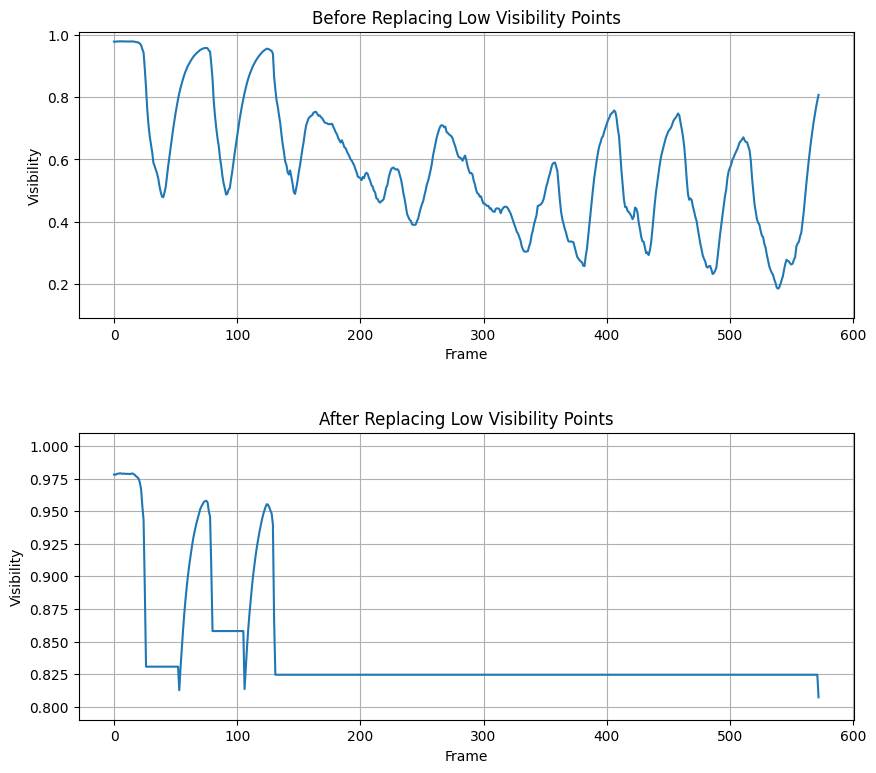

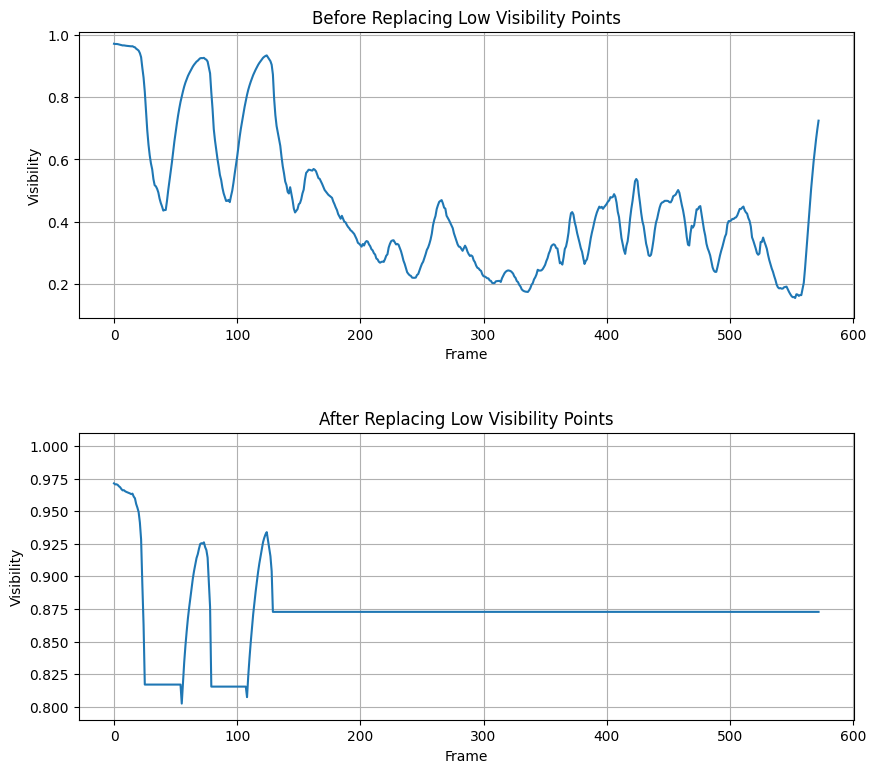

In [8]:
def visibility_mask(visibility_limit, pose_landmarker_results, landmark_index):
    """Create a mask for visibility below a certain limit."""
    num_frames = len(pose_landmarker_results)
    mask = np.zeros(num_frames, dtype=bool)
    for i in range(num_frames):
        visibility = pose_landmarker_results[i]["landmarker_results"].pose_world_landmarkers[0][landmark_index].visibility
        if visibility < visibility_limit:
            mask[i] = True
    return mask

def replace_low_visibility_points(pose_landmarker_results, landmark_index, visibility_limit=0.5):
    """Replace low visibility points with the last high visibility point."""
    num_frames = len(pose_landmarker_results)
    last_high_visibility_point = None

    for i in range(num_frames):
        landmark = pose_landmarker_results[i]["landmarker_results"].pose_world_landmarks[0][landmark_index]
        if landmark.visibility >= visibility_limit:
            last_high_visibility_point = landmark
        else:
            if last_high_visibility_point is not None:
                pose_landmarker_results[i]["landmarker_results"].pose_world_landmarks[0][landmark_index] = last_high_visibility_point
    return pose_landmarker_results

# create a 2,1 subplot of visibility over time for the left wrist (15)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plt.subplot(2, 1, 1)
plot_visibility_over_time(pose_landmarker_results, landmark_index=15)  # Left Wrist
plt.title("Before Replacing Low Visibility Points")
plt.subplot(2, 1, 2)
pose_landmarker_results = replace_low_visibility_points(pose_landmarker_results, landmark_index=15, visibility_limit=0.8)   # Replace low visibility points on the left wrist (15)
plot_visibility_over_time(pose_landmarker_results, landmark_index=15)  # Left Wrist
plt.title("After Replacing Low Visibility Points")
fig.subplots_adjust(top=0.93, bottom=0.07, hspace=0.4)


# create a 2,1 subplot of visibility over time for the left elbow (13)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plt.subplot(2, 1, 1)
plot_visibility_over_time(pose_landmarker_results, landmark_index=13)  # Left Elbow
plt.title("Before Replacing Low Visibility Points")
plt.subplot(2, 1, 2)
pose_landmarker_results = replace_low_visibility_points(pose_landmarker_results, landmark_index=13, visibility_limit=0.8)   # Replace low visibility points on the left elbow (13)
plot_visibility_over_time(pose_landmarker_results, landmark_index=13)  # Left Elbow
plt.title("After Replacing Low Visibility Points")
fig.subplots_adjust(top=0.93, bottom=0.07, hspace=0.4)

Add a FBD to a specific frame

Adding a few arrows to frame 155

In [ ]:
# frame_idx = 155
# landmarkers = pose_landmarker_results[frame_idx]["landmarker_results"]
# original_frame_bgr = pose_landmarker_results[frame_idx][
#     "original_frame"
# ].copy()
# height, width, _ = original_frame_bgr.shape
# force_x_img, force_y_img = (
#     int(landmarkers.pose_world_landmarkers[0][25].x * width),
#     int(landmarkers.pose_world_landmarkers[0][25].y * height),
# )
# # cv2.arrowedLine(
# #     original_frame_bgr,
# #     pt1=(force_x_img, force_y_img),
# #     pt2=(force_x_img + 30, force_y_img),
# #     color=(0, 0, 255),
# #     thickness=4,
# # )
# # force_x_img, force_y_img = (
# #     int(landmarkers.pose_world_landmarkers[0][30].x * width),
# #     int(landmarkers.pose_world_landmarkers[0][30].y * height),
# # )
# # cv2.arrowedLine(
# #     original_frame_bgr,
# #     pt1=(force_x_img, force_y_img),
# #     pt2=(force_x_img, force_y_img - 30),
# #     color=(0, 0, 255),
# #     thickness=4,
# # )

# # force_x_img, force_y_img = (
# #     int(landmarkers.pose_world_landmarkers[0][29].x * width),
# #     int(landmarkers.pose_world_landmarkers[0][29].y * height),
# # )
# # cv2.arrowedLine(
# #     original_frame_bgr,
# #     pt1=(force_x_img, force_y_img),
# #     pt2=(force_x_img, force_y_img + 30),
# #     color=(0, 0, 255),
# #     thickness=4,
# # )

# original_frame_rgb = cv2.cvtColor(
#     original_frame_bgr, cv2.COLOR_BGR2RGB
# )
# annotated_frame = draw_landmarks_on_image(
#     original_frame_rgb,
#     landmarkers,
# )
# plt.close("all")
# plt.imshow(annotated_frame)
# plt.axis("off")  # hide axes
# plt.show()

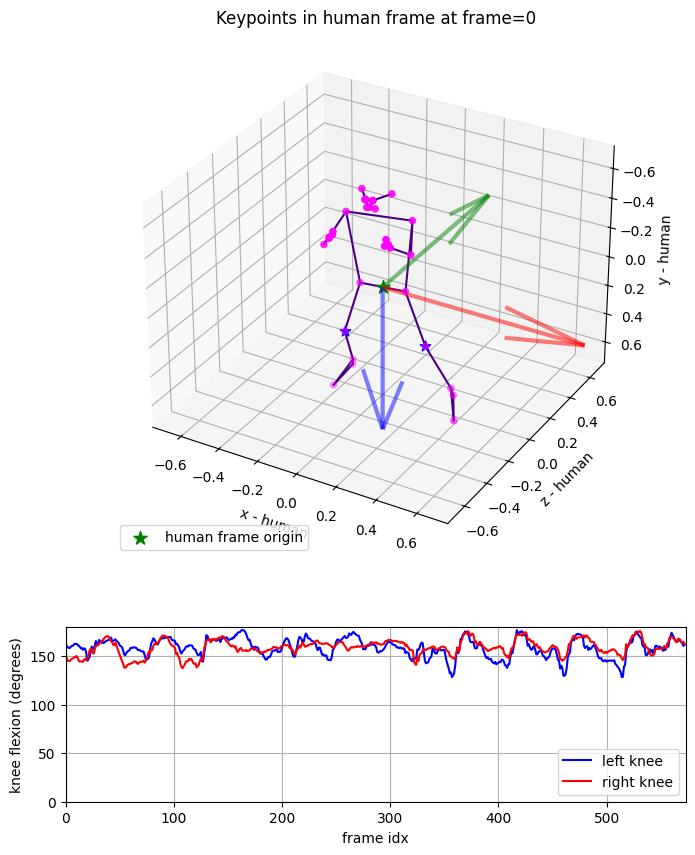

In [ ]:
from matplotlib.animation import FuncAnimation

import matplotlib.gridspec as gridspec

plt.close("all")
fig = plt.figure(figsize=(8, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

ax1 = fig.add_subplot(gs[0], projection="3d")
ax2 = fig.add_subplot(gs[1])

num_frames = len(pose_landmarker_results)

ax2.set(
    xlim=(0, num_frames),
    ylim=(0, 180),
    xlabel="frame idx",
    ylabel="knee flexion (degrees)",
)

left_angles = []
right_angles = []
for result in pose_landmarker_results[:num_frames]:
    left_knee_angle, right_knee_angle = (
        calculate_left_right_knee_flexion(result)
    )
    left_angles.append(left_knee_angle)
    right_angles.append(right_knee_angle)

ax2.plot(range(num_frames), left_angles, color="b", label="left knee")
ax2.plot(
    range(num_frames), right_angles, color="r", label="right knee"
)
ax2.grid(True)
ax2.legend(loc="lower right")

cursor_line = ax2.axvline(0, color="k", linestyle="--")

def update(frame_idx):
    ax1.cla()
    draw_3d_pose_human_frame(pose_landmarker_results[frame_idx], ax1)
    ax1.set_title(f"Keypoints in human frame at frame={frame_idx}")
    cursor_line.set_xdata([frame_idx])

anim = FuncAnimation(
    fig,
    update,
    frames=num_frames,
    interval=50,
)

# anim.save("pose_animation_knee.gif", writer="pillow", fps=15)
anim.save("pose_animation_knee.mp4", writer="ffmpeg", fps=15)

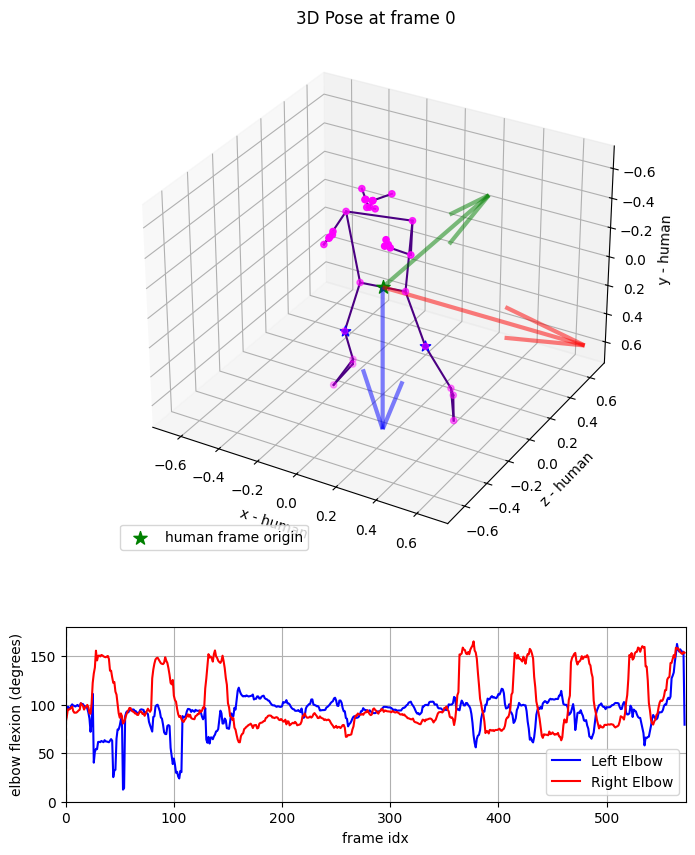

In [9]:
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec

# Close previous figures
plt.close("all")

# Create figure with 2 rows: top=3D pose, bottom=elbow angles
fig = plt.figure(figsize=(8, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

ax1 = fig.add_subplot(gs[0], projection="3d")
ax2 = fig.add_subplot(gs[1])

num_frames = len(pose_landmarker_results)

# Ax2 setup (elbow flexion angle plot)
ax2.set(
    xlim=(0, num_frames),
    ylim=(0, 180),
    xlabel="frame idx",
    ylabel="elbow flexion (degrees)",
)

# Precompute left and right elbow angles
left_elbow_angles = []
right_elbow_angles = []
for result in pose_landmarker_results[:num_frames]:
    left_angle, right_angle = calculate_left_right_elbow_flexion(result)
    left_elbow_angles.append(left_angle)
    right_elbow_angles.append(right_angle)

# Plot static elbow angle curves
ax2.plot(range(num_frames), left_elbow_angles, color="b", label="Left Elbow")
ax2.plot(range(num_frames), right_elbow_angles, color="r", label="Right Elbow")
ax2.grid(True)
ax2.legend(loc="lower right")

# Cursor line to move with animation
cursor_line = ax2.axvline(0, color="k", linestyle="--")

# Update function for each frame
def update(frame_idx):
    ax1.cla()
    draw_3d_pose_human_frame(pose_landmarker_results[frame_idx], ax1)
    ax1.set_title(f"3D Pose at frame {frame_idx}")
    cursor_line.set_xdata([frame_idx])

# Animate
anim = FuncAnimation(
    fig,
    update,
    frames=num_frames,
    interval=50,  # ms per frame
)

# anim.save("pose_animation_elbow.gif", writer="pillow", fps=15)
anim.save("pose_animation_elbow_2.mp4", writer="ffmpeg", fps=15)
